In [1]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyhomogeneity

Note: you may need to restart the kernel to use updated packages.


In [4]:
import netCDF4
import matplotlib.pyplot as plt
import datetime 
import statsmodels as statsmodels
import statistics as stats
import decimal
import os
import numpy as np
import copy
import pyhomogeneity as hg
import scipy.stats as sp


In [5]:


class ReadData:
    """
    ReadData-- generates the dataset
    
    TODO: currently doesn't use generators, so it can be slow.
    """
    DMI_data = {}
    DMI_list = [] #sorted version of the dictionary
    sortedKeys_DMI = []
    TRMM_data = {}
    TRMM_list = []
    TRMM_acc_list = [] #weekly precepitation
    TRMM_mod7 = 6 #this is the only way to get the data to match up with NINO and DMI
    sortedKeys_TRMM = []
    ElNino_data= {}
    ElNino_list = [[],[],[],[]]
    sortedKeys_Nino = [[],[],[],[]] #currently, we have 4 Nino items
    data_dict = {}
    
    #constants
    begin = datetime.date(1998, 1, 1) #begin of dates we look at. We need to start a bit late so we can get 7 previous days to use for acc
    end = datetime.date(2019, 12, 25) #end of dates we look at
    #note that we have to discard this final point to make everything even
    
    
    
    
    def __init__(self):
        
        #in the init phase, we generated each data set and sort the dictionary keys
        
        self.DMI_data = self.generateDataDMI()
        print("DMI data generated")
        self.sortedKeys_DMI = self.sortKeys(self.DMI_data)   
        for i in self.sortedKeys_DMI:
            self.DMI_list.append(self.DMI_data[i])
        
        self.TRMM_data = self.generateDataTrim()
        self.sortedKeys_TRMM = self.sortKeys(self.TRMM_data)  
        for i in self.sortedKeys_TRMM:
            self.TRMM_list.append(self.TRMM_data[i])
        print("TRMM data generated")
        sum_L = self.accumulateTRMM()
        self.TRMM_acc_list = self.takeModN_TRMM(sum_L) #this creates a list with the summed precipitation fo the previous days
        
        #and we only take days that are mod7 == 0
        #
        
        
        
        self.ElNino_data = self.generateDataElNino()
        for i in range(0,len(self.ElNino_data)):
            self.sortedKeys_Nino[i] = self.sortKeys(self.ElNino_data[i])
            for j in self.sortedKeys_Nino[i]:
                self.ElNino_list[i].append(self.ElNino_data[i][j])
                #print(j)
        print("ELNino data generated")
        
    def accumulateTRMM(self):
        TRMM_list_update = [] #because we have to skip first date, we lose one data point
        v_0 = 0
        v_1 = 0
        for i in range(6, len(self.TRMM_list)):
            v_0 += self.TRMM_list[i][0][0]
            v_1 += self.TRMM_list[i][3][3]
            TRMM_list_update.append(copy.deepcopy(self.TRMM_list[i]) ) #arrays are pass by REFRENCE--need to copy.
            for j in range(0,6):
                TRMM_list_update[i-6] += self.TRMM_list[i-j-1]
        print(v_0)
        print(v_1)
        return TRMM_list_update
    def takeModN_TRMM(self,L):
        TRMM_list_res = []
        for i in range(0,len(L)):
            if(i % 7 == self.TRMM_mod7): #only take number with mod of TRMM_mod7
                TRMM_list_res.append(L[i])
                #look at this sorted key, why are we missing the last key?
            
        return TRMM_list_res
    
        
    def sortKeys(self,data):
        return sorted(data,key = lambda key: self.toDateTime(key )-self.begin)
    def findMinData(self,data):
        v = 0
        for key in data.keys():
            diff = self.toDateTime(key )-self.begin
            if(v == 0 or v> diff):
                v = diff
        print(v)
        return v
        
        
    
    """
    Generate DMI dataset--used for (???)
    """
    def generateDataDMI(self):
        iodfile = "dmi.nc" #were reading the DMI file
        f = netCDF4.Dataset(iodfile, 'r')
        SSTAnp=f.variables['DMI'][:]
        weeknp=f.variables['WEDCEN2'][:]
        SSTA=SSTAnp.tolist() #list of DMI SSTA
        week=weeknp.tolist() 
        f.close()
        DMIdate=[]     #DATE OF DMI 
        for i in range(0, len(week)):    
            days=week[i]
            start=datetime.date(1900, 1, 1)
            delta=datetime.timedelta(days)
            offset=start+delta
            DMIdate.append(offset)

        date_DMI={}
        skip = True
        for j in range(0, len(SSTA)): #skip first data point, so we can meet with TRMM
            if(self.isInTimeRange(DMIdate[j])):
                if(not skip):
                    date_DMI[str(DMIdate[j]).replace("-","")] =  SSTA[j]
                else:
                    skip = False #skip one data point
            else:
                pass
                #this data we will just discard for now
        #print("len",len(date_DMI)) 1146 length, since we skip one data point
        return date_DMI
    
    def generateDataElNino(self):
        ninoindicesfile="elnino indices.txt"
        f=open(ninoindicesfile, "r")
        linelist=list(f.readlines())    
        #### ARRAYS OF FORMAT (DATETIME, DMI)
        date_Ninos=[{},{},{},{}]
        #12,3,34,4 are the ninos we take
        
        search_range = [[19,23],[32,36],[45,49],[58,62]]
        
        for j in range(0,len(search_range)):
            skip = True
            for i in range(4, len(linelist)): #skip the first datapoint
                date_str = self.replaceDateTime(linelist[i][1:10])
                if (self.isInTimeRangeStr(date_str)):
                    if(not skip):
                        date_Ninos[j][date_str] =  float(linelist[i][search_range[j][0]:search_range[j][1]])            
                    else:
                        skip = False
                else:
                    pass
                    #this is the date we discard
            print(len(date_Ninos[j]) )  #is 1146, since we skip one point
        f.close() 

        
        
        return date_Ninos
    """
    Generate TRMM dataset
    """
    def generateDataTrim(self): #this is very slow, potentially increase speed at some point
        TRMMfolder="TRMM1/"
        datetime_prec={} #create a dictionary with the dates
        for filename in os.listdir(TRMMfolder):
            if filename.endswith('nc4'):
                f=netCDF4.Dataset(TRMMfolder + str(filename))
                precp=f.variables['precipitation'][:]
                
                date_str = str(filename[11:19])
                #if(self.isInTimeRangeStr(date_str) and not str(self.toDateTime(date_str)-self.begin)=="0:00:00" and int(str(self.toDateTime(date_str)-self.begin).split(" ")[0]) % 7 == self.TRMM_mod7  ):
                if(self.isInTimeRangeStr(date_str)):    
                    datetime_prec[date_str] =  precp
                else:
                    pass
                f.close()
            else:
                pass
        
        #datetime_prec=np.array(datetime_prec)
        return datetime_prec
    def isInTimeRange(self,time):
        if (time >= self.begin and time <= self.end):
            return True
        return False
    def toDateTime(self,time):
        return datetime.date(int(time[0:4]),int(time[4:6]),int(time[6:8]))
    def isInTimeRangeStr(self,time):
        return self.isInTimeRange(self.toDateTime(time))
        
        
    def replaceDateTime(self,string):
        return str(datetime.datetime.strptime(string, '%d%b%Y')).split(" ")[0].replace("-","")
    
    
        
    
    
    





reader = ReadData()
    









DMI data generated
TRMM data generated
46684.300396738574
22556.258356884122
1146
1146
1146
1146
ELNino data generated


In [6]:
class AnalyzeData:
    "class for anaylzing the data we generated from a reader"
    reader_class = None
    snhtsetDMI = []
    snhtsetNino = []
    snhtsetTRMM = []
    mx_lon = 13
    mx_lat = 11
    def __init__(self,reader):
        self.reader_class = reader
        #self.generateAllSNHT()
    def generateAllSNHT(self):
        self.snhtsetTRMM= [] #the snht set is ordered as a list (lon,lat,?)
        for lon in range(0,self.mx_lon):
            lat_list = []
            for lat in range(0,self.mx_lat):
                #print("trmm",type(self.getDatasetTRMM(lon,lat)[0]))
                lat_list.append(self.SNHTALL(self.getDatasetTRMM(lon,lat)))
                pass
            self.snhtsetTRMM.append(lat_list)
        
        #TODO: continue with taking the snhtset
    def getDatasetTRMM(self,lon,lat):
        #right now, we don't check to ensure the list is correctly sized, add that later
        #i,j means for each item, take the ith item, and the jth item from that list, and form it into a dataset
        list_res = []
        
        for item in self.reader_class.TRMM_acc_list:
            list_res.append(item[lon][lat])
        
        return list_res
    #(Old snht test)
    
    def SNHTALL(self,dataset):   #SNHT FOR time series of dimension 1 x n
        n=len(dataset)
        sd=np.std(dataset)
        mean = stats.mean(dataset)
        
        snhtset=[]
        #mx_v = 0
        for y in range(1,n-1): #Loops from Week 1 to week n-1
            summ1=0 
            for i in range(0, y): 
                summ1 += dataset[i]-mean
            z_1= (1.0/(y*sd)) * (summ1)
            summ2=0
            for i in range(y, n):
                summ2 += dataset[i]-mean
            z_2= (1/( (n-y)*sd)) * (summ2)
            v = y * (z_1 **2) + (n-y)*(z_2**2)
            snhtset.append(v)
        
        return snhtset

    def Pearson(self,x, y, lag): #LAG means that we compare x_t against y_{t-lag} where lag is positive
        if int(lag)!=0:
            x=x[lag:]
            y=y[:-lag]
        else:
            pass
        cor, pval=sp.pearsonr(x, y)
        return [lag, cor, pval]

analyze = AnalyzeData(reader) 

#analyze.generateAllSNHT()

In [7]:
#LIST ACTIONS:
#contains useful functions on lists
def checkEq(L,L2):
    return (len(L)==len(L2)) #check any other required properties here
def subtract(L,L2): #put the larger list first
    if (len(L)<len(L2)):
        print("Warning: Larger list should go first!")
    res = []
    for i in range(len(L2)):
        res.append( L[i] - L2[i])
    return res
def forwardDifference(L):
    return subtract(applyLag(L,1),L[:len(L)-1])
def getTRMMid(L,i,j):
    return applyFunc(L,lambda x: x[i][j])
def applyLag(L,lag):
    return L[lag:]
def applyFunc(L,func):
    res = []
    for i in L:
        res.append(func(i))
    return res
def getMax(L):
    mx = L[0]
    for i in L:
        if (i > mx):
            mx = i
    return mx
def deviationStrength(L):
    return applyFunc(splitDeviation(L),lambda x: x[1])
def outlierStrength(L,power):
    mx = getMax(deviationStrength(L))
    return applyFunc(deviationStrength(L), lambda x: (x/mx)**power)
def splitDeviation(L):
    mean = stats.mean(L)
    return applyFunc(L,lambda x: [0 if x-mean == 0 else (x-mean)/abs(x-mean), abs(x-mean)] )
def checkSquareDiffLag(L,L2,lag):
    return sum(squareDiff(L[:len(L)-lag],applyLag(L2,lag)))/(len(L)-lag)
def squareDiff(L,L2):
    if(checkEq(L,L2)):
        return applyFunc(subtract(L,L2),lambda x: x*x)
        
    else:
        print("lists different lengths!")
#smoothing functions
def windowAvg(L,t):
    res = []
    sums = 0
    for i in range(len(L)-t):
        sums = sum(L[i:i+t])
        res.append(sums)
    return res
def movingAvg(L,mult):
    res = []
    sums = 0
    for i in range(len(L)):
        sums += L[i]
        sums *= mult
        res.append(sums)
    return res



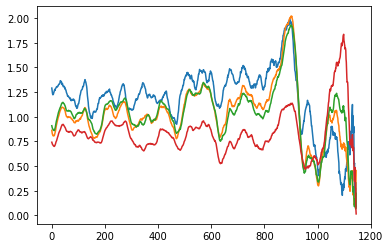

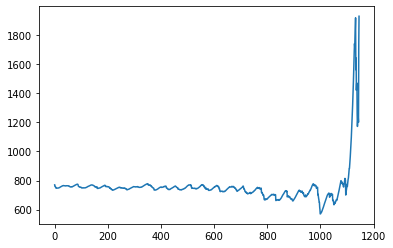

In [16]:
for j in range(len(reader.ElNino_list)):
    vals = []
    for i in range(len(reader.ElNino_list[j])):
        vals.append(checkSquareDiffLag(reader.DMI_list,reader.ElNino_list[j],i))
    plt.plot(vals)
plt.show()

#for j in range(len(reader.ElNino_list)):
for j in range(1):
    for lat in range(0,5):    
        vals = []
        L = getTRMMid(reader.TRMM_acc_list,lat,0)
        for i in range(len(reader.ElNino_list[j])):
            vals.append(checkSquareDiffLag(L,reader.ElNino_list[j],i))
    plt.plot(vals)
plt.show()

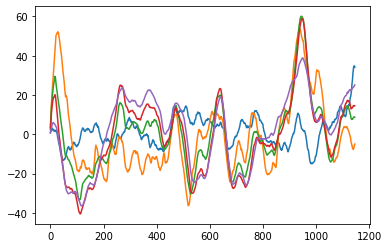

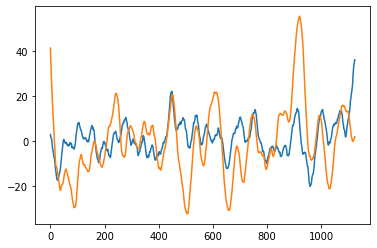

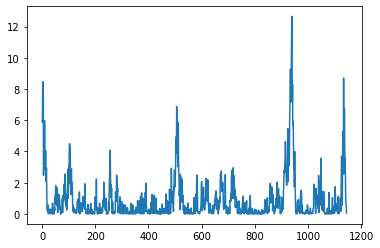

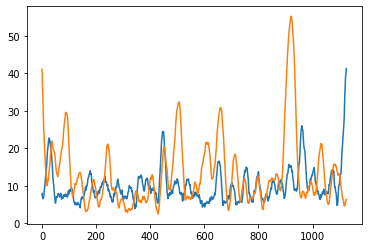

In [10]:

plt.plot(movingAvg(reader.DMI_list,.97) )
plt.plot(movingAvg(reader.ElNino_list[0],.97) )
plt.plot(movingAvg(reader.ElNino_list[1],.97) )
plt.plot(movingAvg(reader.ElNino_list[2],.97) )
plt.plot(movingAvg(reader.ElNino_list[3],.97) )
plt.show()

plt.plot(windowAvg(reader.DMI_list,20) )
plt.plot(windowAvg(reader.ElNino_list[1],20) )
plt.show()

plt.plot(squareDiff(reader.DMI_list,reader.ElNino_list[1] ))
plt.show()

plt.plot(windowAvg(applyFunc(splitDeviation(reader.DMI_list),lambda x: x[1]*1.2),20) )
plt.plot(windowAvg(applyFunc(splitDeviation(reader.ElNino_list[1]),lambda x: x[1]),20) )
plt.show()



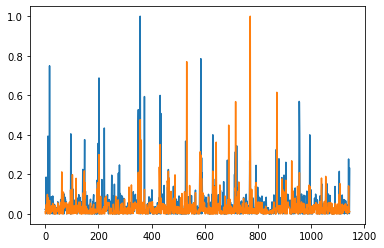

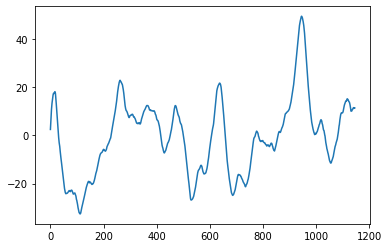

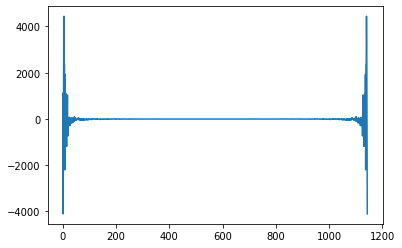

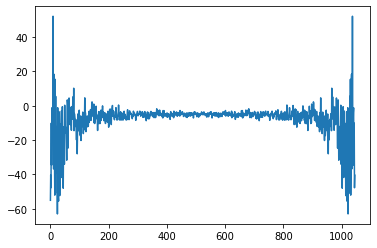

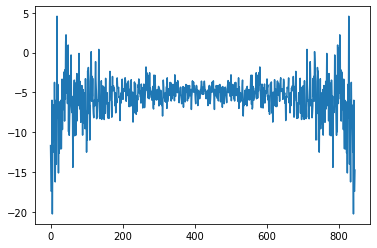

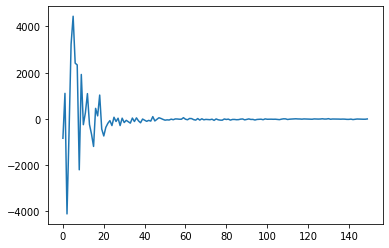

In [14]:
import numpy
for i in range(0,2):
    #plt.plot(applyFunc(splitDeviation(getTRMMid(reader.TRMM_acc_list,i,i)),lambda x: x[1]))
    plt.plot(outlierStrength(getTRMMid(reader.TRMM_acc_list,i,i),2))
plt.show()
#res = windowAvg(getTRMMid(reader.TRMM_acc_list,i,i),7)
res = movingAvg(reader.ElNino_list[2],.96)
plt.plot(res)
plt.show()
res = numpy.fft.fft(res)
"""
for i in range(20):
    #plt.plot(applyFunc(res[1:],lambda x: x.imag))
    re = applyFunc(res[10:],lambda x: x.real)
    

    res = numpy.fft.fft(res[1:])[1:]
"""
plt.plot(res[1:-1])
plt.show()
plt.plot(res[50:-50])
plt.show()
plt.plot(res[150:-150])
plt.show()
plt.plot(res[0:150])
plt.show()


[[21, 0.09020963197303966], [25, 0.06387299995052681], [22, 0.043072135908035616], [25, 0.04163396495340008], [21, 0.031744006502969935], [19, 0.021559430674371223], [25, 0.03809178123012172], [5, 0.046605685625221674], [5, 0.07169239605714806], [0, 0.05628189602486176], [4, 0.057520671195552535]]
1115 1115


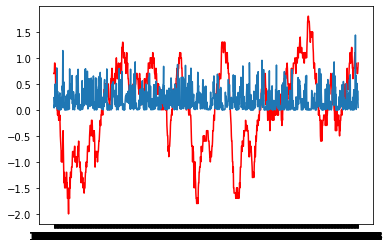

In [15]:
b=reader.ElNino_list[3]
pearlarray=[]
for k in range(0, 13):
    lat=[]
    for i in range(0, 11):
        a=[reader.TRMM_acc_list[j][k][i]/100 for j in range(0, 1146)]
        current=analyze.Pearson(a, b, 0)
        for l in range(0, 52):
            new=analyze.Pearson(a,b,l)
            if float(new[1])>float(current[1]):
                current=analyze.Pearson(a,b,l)
            else:
                pass
        lat.append([current[0], current[1]])
    #print(lat)
    pearlarray.append(lat)
print(pearlarray[0])
a=a[31:]
b=b[:-31]
print(len(a), len(b))
c=list(reader.sortedKeys_DMI[31:1146])
plt.plot(c, b, color='r')
plt.plot(c, a)
plt.show()

In [ ]:
#we can create a csv file here
def writeLine(lst): #list [n,n2]
    res  = ""
    for i in lst:
        string = ""
        for j in i:
            string += str(j) + ","
        res += string[0:len(string)-1]
    
        res += "]"
    return res
    
def writeToFile():
    with open('Precip.txt', 'w') as f:
        for i in reader.TRMM_acc_list:
            f.write(writeLine(i) + "\n")
            
writeToFile()
